[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/lyeskhalil/mlbootcamp2022/blob/main/lab_3_1_neuralnets.ipynb)

# UofT FASE ML Bootcamp
#### Wednesday June 16, 2022
#### Convolutional Neural Network - Lab 1, Day 3 
#### Teaching team: Elias Khalil, Alex Olson, Rahul Patel, and Jake Mosseri
##### Lab author: Rahul Patel, rm.patel@mail.utoronto.ca
##### Adapted from: [Transfer learning for computer vision tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#transfer-learning-for-computer-vision-tutorial)


In this lab, we will learn about convolution neural networks (CNN) and how to do transfer learning using a pretrained CNN for an image classification task.

In [2]:
!pip3 install torch torchvision
!pip install numpy
!pip install matplotlib

# Basic imports
import os
import copy

import numpy as np
import matplotlib.pyplot as plt
from time import time

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Convolution Neural Networks

A CNN is a type of model which allows us to efficiently extract features from image data to perform various downstream tasks like image classification, segmentation etc, providing  better `inductive-bias` for image-based models than feed-forward neural networks (FFNN). 

- Local connectivity
- Parameter sharing



### Transfer learning

Quoting the [cs231n notes](https://cs231n.github.io/transfer-learning/),

`
In practice, very few people train an entire Convolutional Network from scratch (with random initialization), because it is relatively rare to have a dataset of sufficient size. Instead, it is common to pretrain a ConvNet on a very large dataset (e.g. ImageNet, which contains 1.2 million images with 1000 categories), and then use the ConvNet either as an initialization or a fixed feature xtractor for the task of interest.
`

These two major transfer learning scenarios look as follows:

- **ConvNet as fixed feature extractor**: Here, we will freeze the weights for all of the network except that of the final fully connected layer. This last fully connected layer is replaced with a new one with random weights and only this layer is trained.

- **Finetuning the ConvNet**: Here, instead of random initialization, we initialize the network with a pretrained network, like the one that is trained on imagenet 1000 dataset. Rest of the training looks as usual.

In [4]:
# Necessary imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import datasets, models, transforms

cudnn.benchmark = True
plt.ion()  

### Load Data

We will use `torchvision` and `torch.utils.data` packages for loading the data.

The problem we’re going to solve today is to train a model to classify ants and bees. We have about 120 training images each for ants and bees. There are 75 validation images for each class. Usually, this is a very small dataset to generalize upon, if trained from scratch. Since we are using transfer learning, we should be able to generalize reasonably well.

This dataset is a very small subset of ImageNet.

In [5]:
# Download the dataset from Pytorch's website
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip ./hymenoptera_data.zip

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = './hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

# Determine whether a GPU is available for training or not.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

--2022-06-16 08:26:08--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 108.138.94.32, 108.138.94.103, 108.138.94.65, ...
Connecting to download.pytorch.org (download.pytorch.org)|108.138.94.32|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M   288MB/s    in 0.2s    

2022-06-16 08:26:08 (288 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]

Archive:  ./hymenoptera_data.zip
replace hymenoptera_data/train/ants/0013035.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: hymenoptera_data/train/ants/0013035.jpg  
  inflating: hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: hymenoptera_data/train/ants/1099452230_d1949d3250.jpg  
  inflating: hymenoptera_data/train/ants/116570

### Visualize a few images

Let’s visualize a few training images so as to understand the data augmentations. 

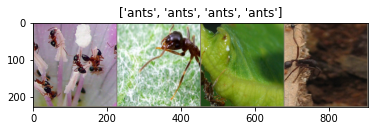

In [6]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

### Training loop

Now, let’s write a general function to train a model. Here, we will illustrate:

- Scheduling the learning rate
- Saving the best model

In the following, parameter `scheduler` is an LR scheduler object from `torch.optim.lr_scheduler`.

In [7]:
# Training loop

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

### Visualizing the model predictions

Generic function to display predictions for a few images

In [8]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

### ConvNet as fixed feature extractor
Here, we need to freeze all the network except the final layer. We need to set `requires_grad = False` to freeze the parameters so that the gradients are not computed in `backward()`.

You can read more about this in the documentation [here](https://pytorch.org/docs/master/notes/autograd.html).

**YOUR TURN**:

- Load a ResNet18 model using `torchvision.models` with pretrained weights: Follow the instructions [here](https://pytorch.org/vision/stable/models.html) to learn about constructing CNN models with standard architectures used in the literature. 

For example: For creating an AlexNet, the CNN architecture proposed by Geoff Hinton and group that won the ImageNet competition *in* 2012, with pretrained weights we call:

`alexnet = torchvision.models.alexnet(pretrained=True)` 

- What is the size of the final and penultimate layers?

In [9]:
model_conv = # YOUR CODE HERE TO LOAD A PRETRAINED ResNet18

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

**YOUR TURN**:

- Freeze the weights of the pretrained ResNet18: By default, the model parameters of the model that we just loaded can be further optimized. To determine whether a parameter can be tuned or not we can check their `required_grad` attribute. If we set this to `False`, `PyTorch` will not optimize these weights on the `.backward()` call. 

Hint: `print(param.requires_grad)`

In [ ]:
# Access all the parameters of the model
for param in model_conv.parameters():
    # Modify the param to freeze it
    # YOUR CODE HERE

In [8]:
# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.9221 Acc: 0.5205
val Loss: 0.4931 Acc: 0.8039

Epoch 1/24
----------
train Loss: 0.4521 Acc: 0.7910
val Loss: 0.1666 Acc: 0.9346

Epoch 2/24
----------
train Loss: 0.5727 Acc: 0.7541
val Loss: 0.1643 Acc: 0.9542

Epoch 3/24
----------
train Loss: 0.5199 Acc: 0.7869
val Loss: 0.1772 Acc: 0.9412

Epoch 4/24
----------
train Loss: 0.5280 Acc: 0.7582
val Loss: 0.1650 Acc: 0.9477

Epoch 5/24
----------
train Loss: 0.5864 Acc: 0.7623
val Loss: 0.2032 Acc: 0.9477

Epoch 6/24
----------
train Loss: 0.2952 Acc: 0.8566
val Loss: 0.2135 Acc: 0.9412

Epoch 7/24
----------
train Loss: 0.4297 Acc: 0.8074
val Loss: 0.2080 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.3106 Acc: 0.8607
val Loss: 0.2282 Acc: 0.9477

Epoch 9/24
----------
train Loss: 0.3204 Acc: 0.8811
val Loss: 0.1868 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.3922 Acc: 0.8320
val Loss: 0.2031 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.4188 Acc: 0.8320
val Loss: 0.2132 Acc: 0.9477

Epoch 12/24
----------
t

**YOUR TURN**:

- Can you think of a better way to perform the forward pass to reduce computations and improve the training time? *Hint:* Can we cache something?

### Finetuning the ResNet18

In the first part, we used ResNet18 as a fixed feature extractor and only modified and tuned the final as per our needs. What if we want to tune the entire network instead?

**YOUR TURN**:

- Finetune ResNet18: Modify the code below to make ResNet18 finetunable
- Play with the learning rate of the optimizer

In [ ]:
model_conv = # YOUR CODE HERE TO LOAD A PRETRAINED ResNet18

# Access all the parameters of the model
for param in model_conv.parameters():
    # Modify the param to freeze it
    # YOUR CODE HERE

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

**YOUR TURN**

- Which transfer learning method (fine-tuning or feature-extraction) you would prefer when size of the dataset is small/large? Explain
- Assume you have access to a trained model that can do classify various fruits. Suppose we do transfer learning for the below mentioned scenarios, how well would it perform?
    - Classify various vegetables
    - Classify cell images
    - Classify satellite images
- Can you think of a way to reduce the number of parameters of the ResNet18 model for our task? *Hint*: Think about the size of the output layer. Can we do better?


***Extra***:

- Assume you are given a dataset of RGB images of cats and dogs of size 100 x 100 pixels. Suppose that we want to train an image classification model using this dataset such that once trained, it should be able to correctly classify a new cat/dog input image.
    - Calculate the number of parameters for a used to perform this task with the following architecture
        - Linear layer: Output size 100
        - Linear layer: Output size 100
        - Linear layer: Output size 100
        - Linear layer: Output size 100
        - Linear layer: Output size 1 
    - Calculate the number of parameters for a CNN with the following architecture
        - Convolution layer: 5x5 kernel with 32 filters, padding 2, stride 1
        - Pooling layer: 2x2 kernel, stride 2       
        - Convolution layer: 5x5 kernel with 64 filters, padding 2, stride 1
        - Pooling layer: 2x2 kernel, stride 2        
        - Convolution layer: 5x5 kernel with 128 filters, padding 2, stride 1
        - Pooling layer: 2x2 kernel, stride 2        
        - Convolution layer: 5x5 kernel with 256 filters, padding 2, stride 1
        - Pooling layer: 2x2 kernel, stride 2
        - Linear layer: Output size 100 (the input size can be determined from the previous layers)
        - Linear layer: Output size 1    